In [1]:
import numpy as np
import pandas as pd
import xgboost
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import time
start = time.time()

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define Function Area
### 1. get_var: find the verbal features 
### 2. var_numeric: use label encoder to transfer verbal features
### 3. reshape_data: auto transfer all features to label encode or onehot encode
### 4. plot_Curve: plot the PR and ROC curve of all the algorithms

In [2]:
def fill_missing(data):
            
    data = data.replace(" ?", np.nan)
    
    for col in missing_col:
        top = data[col].describe().top
        data[col] = data[col].fillna(value=top)
        
    return data

In [3]:
def get_var(dataframe):
    
    get_vars = []
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            get_vars.append(col)

    return get_vars

In [4]:
def var_numeric(dataframe):
   
    get_vars = dataframe.columns
    le = sklearn.preprocessing.LabelEncoder()
    
    for col in get_vars:
        dataframe[col] = le.fit_transform(dataframe[col])
        print("{col} transform to {num_col}".format(col=col,num_col='num_'+col))

    return dataframe

In [5]:
def reshape_data(dataframe,encoder = "label"):
    
    
    # using onehot for va
    if encoder == "label":
        df_trans = var_numeric(dataframe)
    else:
        var_feature = get_var(dataframe)
        df_num = dataframe.drop(var_feature,axis=1)
        df_var = dataframe[var_feature]

        df_trans = pd.get_dummies(df_var)
        #df_trans.columns =["col{0}".format(i) for i in range(df_trans.shape[1])]
        
        for col in list(df_num.columns):
            #df_trans.loc[:,col] = df_num[col].astype("int64")
            df_trans[col] = sklearn.preprocessing.minmax_scale(df_num[col])
            #df_trans[col] = df_num[col]
    
    
    # some columns would cause conflic when using algorithm
    
    df_trans.rename(columns={"max_glu_serum_>200":"max_glu_serum_200","max_glu_serum_>300":"max_glu_serum_300","A1Cresult_>7":"A1Cresult_7","A1Cresult_>8":"A1Cresult_8"})
    return df_trans

In [6]:
def plot_Curve(dic,y_test):
    plt.figure(figsize=(20,20))
    for key in dic.keys():
        pred=dic.get(key)
        # plot PR Curve
        plt.subplot(211)
        pr, re, _ = sklearn.metrics.precision_recall_curve(y_test,pred)
        plt.plot(re,pr,label=key,linewidth = 3)
        plt.legend(loc='best',prop = {"size":20})
        plt.xlabel('Recall',fontsize ='20' )
        plt.ylabel('Precision',fontsize= '20' )
        plt.title("PR_Curve")
        
        #plot ROC Curve
        plt.subplot(212)
        fpr, tpr, _  = sklearn.metrics.roc_curve(y_test,pred)
        plt.plot(fpr,tpr,label=key,linewidth = 3)
        plt.legend(loc='best',prop = {"size":20})
        plt.xlabel('False Positive Rate',fontsize ='20')
        plt.ylabel('True Positive Rate',fontsize= '20' )
        plt.title("ROC_Curve")

# 1. Preprocessing
## 1.1 Read data

In [7]:
# That's use to find the dataset folder
cd E:\courses\term2\machine learning\project

E:\courses\term2\machine learning\project


In [8]:
# Read Data and transform label
df = pd.read_csv("diabetic_data.csv")
df.loc[df.readmitted=="NO","readmitted"]=">30"


## 1.2 Find missing value

In [9]:
# count missing

missing_num = np.sum(np.array(df) == "?",axis =0)
missing_filter  = missing_num>0
missing_col = df.columns[missing_filter]

missing_df = pd.DataFrame(
{"number of missing":missing_num[missing_filter],"pecentage":missing_num[missing_filter>0]/df.shape[0]*100},index= missing_col).T
missing_df

,race,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3
number of missing,2273.000000,98569.000000,40256.000000,49949.000000,21.000000,358.000000,1423.000000
pecentage,2.233555,96.858479,39.557416,49.082208,0.020636,0.351787,1.398306


---------------------------------------------------------------------------------------------------------------------------------------
## 1.3. Add new feature
### 1.3.1 count patients' reactions for 24 medications
### 1.3.2 count each patient's come back times in this data set
### 1.3.3 use GMM/EM model to find clusters as new features based on the original numeric features

In [10]:


# medications' name
medications_name = df.columns[24:-3]
df=fill_missing(df)

# count the total reaction of 
df["num_no"] = np.sum(df[medications_name]=="No",axis=1)
df["num_down"] = np.sum(df[medications_name]=="Down",axis=1)
df["num_steady"] = np.sum(df[medications_name]=="Steady",axis=1)
df["num_up"] = np.sum(df[medications_name]=="Up",axis=1)


# count come back times of each patients in this table
df["comback_times"]=df.patient_nbr.map(df.patient_nbr.value_counts())

# count people visit hospital times
df["countyear_visit"]=df[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)


gmm_features = df[["num_lab_procedures","num_procedures","num_medications","comback_times","time_in_hospital"]]
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(gmm_features)

gmm_label = ["gmm_1","gmm_2","gmm_3","gmm_4","gmm_5"]
a=pd.DataFrame(gmm.predict_proba(gmm_features)*20,columns=gmm_label)
df=df.merge(a,left_index =True,right_index=True)


## 1.4. Transform feature

In [11]:
# transfer label to numeric
df["readmitted"] = sklearn.preprocessing.LabelEncoder().fit_transform(df["readmitted"])

# transform feature "weight"

df.loc[:,"weight"] = df["weight"].replace("?",0)
df.loc[:,"weight"] = df["weight"].replace("\>|\[|\-.*","",regex=True).astype("float")

# reclassfy the discarge type into bigger category
df.loc[:,"age"] = df["age"].replace("\[|\-.*","",regex=True).astype("int64")
# unknown
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([18,25,26],0) # not mentioned
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([1,6,8,13,14],1) # go home with assistance
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([2,3,4,5],2) # need help
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([9,10,12,13,14,15,16,17,22,23,24],3)
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([11,19,20,21],4) #die

# Change diag code to bigger classfication
# base on the standard of ICD-9 format

dignose_col = ["diag_1","diag_2","diag_3"]
diag_code = [-1,0,139,239,279,289,319,389,459,519,579,629,679,709,739,759,779,799,999,1999,2001]
df.loc[:,dignose_col]=df[dignose_col].replace("^\?",0,regex=True)
df.loc[:,dignose_col]=df[dignose_col].replace("^V",1000,regex=True)
df.loc[:,dignose_col]=df[dignose_col].replace("^E",2000,regex=True)

df[dignose_col].astype("float64")
for i in dignose_col:
    df.loc[:,i] = pd.cut(pd.to_numeric(df[i]),diag_code,labels = False)



In [12]:
# drop features
ratio = df[df["readmitted"]==0].shape[0]/df[df["readmitted"]==1].shape[0]
label = df["readmitted"]
features = df.drop(["readmitted","encounter_id","patient_nbr"],axis=1)
features = features.drop(medications_name,axis=1)

</br>
<br /></br>
<br /></br>
<br />
# 2. Machine Learning


## 2.1. Rebalance Data and split train/test set

In [13]:

# use reshape fuction to transform the rest of features
features = reshape_data(features,encoder = "onehot")

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [14]:

X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(features, label, test_size=0.3)

from imblearn.over_sampling import SMOTE
column_name = X_train.columns
X_train,y_train = SMOTE().fit_sample(X_train,y_train)
X_train = pd.DataFrame(X_train,columns = column_name)
X_train_noGMM =X_train.drop(gmm_label,axis=1)
X_test_noGMM =X_test.drop(gmm_label,axis=1)

 ---------------------------------------------------------------------------------------------------------------------------------------

## 2.2 SVM

In [15]:
from sklearn.svm import LinearSVC
def run_SVM(X_train,X_test):
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_pred_prob = svm.decision_function(X_test)
    svm_accuracy = sklearn.metrics.accuracy_score(y_test, svm_pred)
    print("Accuracy : ",svm_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,svm_pred))
    print(k)
    return svm_pred_prob
SVM_nogmm_prob = run_SVM(X_train_noGMM,X_test_noGMM)
SVM_gmm_prob = run_SVM(X_train,X_test)

Accuracy :  0.7201768752047166
      0      1
0  1919   1494
1  7049  20068
Accuracy :  0.6609564362921716
      0      1
0  2463    950
1  9401  17716


## 2.3 Logsic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
def run_lg(X_train,X_test):
    lg = LogisticRegression(C=1)
    lg.fit(X_train,y_train)
    lg_pred = lg.predict(X_test)
    lg_pred_prob = lg.predict_proba(X_test)[:,1]
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,lg_pred))
    lg_accuracy = sklearn.metrics.accuracy_score(y_test, lg_pred)
    print("Accuracy : ",lg_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,lg_pred))
    print(k)
    
    return lg_pred_prob
lg_nogmm_prob = run_lg(X_train_noGMM,X_test_noGMM)
lg_gmm_prob = run_lg(X_train,X_test)


Accuracy :  0.7243694726498526
      0      1
0  1944   1469
1  6946  20171
Accuracy :  0.6700294792007861
      0      1
0  2407   1006
1  9068  18049


## 2.4 Nerual Network 

In [17]:
import tensorflow as tf
def run_nn(X_train,X_test):
    
    # Images and their corresponding labels
    x_d = X_train.shape[1]
    fea = tf.placeholder(tf.float32, [None,x_d])
    ans = tf.placeholder(tf.float32, [None, 1])

    #den_0 = tf.layers.dense(inputs=fea, units=500, activation=tf.nn.relu)
    #den_0 = tf.nn.dropout(den_0,0.8)
    den_1 = tf.layers.dense(inputs=fea, units=200, activation=tf.nn.relu)
    den_1 = tf.nn.dropout(den_1,0.8)
    den_2 = tf.layers.dense(inputs=den_1, units=100, activation=tf.nn.relu)
    den_2 = tf.nn.dropout(den_2,0.8)
    den_3 = tf.layers.dense(inputs=den_2, units=30, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=den_3, units=1)
    output = tf.nn.sigmoid(logits, name="sigmoid_tensor")
    # Forward passs -- compute the cross entropy and output probabilities
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=ans,logits=logits,weights = 0.1)


    # Backward pass
    # Note: you don't need to compute the gradient 
    # Simply use the tf.train.AdamOptimizer() function
    train = tf.train.AdamOptimizer(0.01).minimize(loss)

    # Compute Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1), tf.argmax(ans,1)),tf.float32))


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    from sklearn.utils import shuffle

    # Batch size for evaluation performance
    batchSz = 5000

    print("Training on 2000 batches:") 
    step = 500
    for i in range(step):
        if i % step == 0: sstart = time.time()  
        X_, y_ = shuffle(X_train, y_train)
        X_ = X_.values[:batchSz,:].reshape([batchSz,x_d])
        y_ = y_[:batchSz].reshape([batchSz,1])

        sess.run(train, feed_dict={fea: X_, ans: y_})
        if (i+1) % step == 0:
            sstop = time.time()
            print('batches %s - %d, duration ~ %g sec' % (i-(step-2), i+1, (sstop - sstart)))
        
    nn_prob = sess.run(output, feed_dict={fea: X_test, ans: y_test.reshape([y_test.shape[0],1])})
    nn_prob=[i[0] for i in nn_prob]
    nn_pred =[1 if i>0.5 else 0 for i in nn_prob] 
    nn_accuracy = sklearn.metrics.accuracy_score(y_test, nn_pred)
    print("Accuracy : ",nn_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,nn_pred))
    print(k)
    sess.close()
    
    return nn_prob
nn_nogmm_prob = run_nn(X_train_noGMM,X_test_noGMM)
nn_gmm_prob = run_nn(X_train,X_test)


d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Training on 2000 batches:
batches 1 - 500, duration ~ 72.1566 sec


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Accuracy :  0.7523419587291189
      0      1
0  1679   1734
1  5827  21290
Training on 2000 batches:
batches 1 - 500, duration ~ 82.0341 sec
Accuracy :  0.7136259416966918
      0      1
0  1956   1457
1  7286  19831


## 2.5 Xgboost 

In [18]:
import xgboost
def run_xgb(X_train,X_test):
    xgb= xgboost.XGBClassifier(n_estimators =200,max_depth =8,learning_rate = 0.2,scale_pos_weight=ratio)

    xgb.fit(X_train, y_train)

    xgb_pred = xgb.predict(X_test) 
    xgb_pred_prob = xgb.predict_proba(X_test)[:,1]

    xgb_accuracy = sklearn.metrics.accuracy_score(y_test, xgb_pred)
    xgb_roc = sklearn.metrics.roc_auc_score(y_test, xgb_pred_prob)
    print("Accuracy : ",xgb_accuracy)
    print("ROC Score : ",xgb_roc)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,xgb_pred))
    print(k)
    return xgb_pred_prob
xgb_nogmm_prob = run_xgb(X_train_noGMM,X_test_noGMM)
xgb_gmm_prob = run_xgb(X_train,X_test)


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy :  0.7463806092368163
ROC Score :  0.774842974342574
      0      1
0  2116   1297
1  6446  20671


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy :  0.7435637078283656
ROC Score :  0.7806930512969263
      0      1
0  2191   1222
1  6607  20510


## 2.6 Stacking

In [25]:


merge = {
  'SVM_nogmm_prob': SVM_nogmm_prob,
  'SVM_gmm_prob': SVM_gmm_prob,
  'lg_nogmm_prob': lg_nogmm_prob,
  'lg_gmm_prob': lg_gmm_prob,
  'nn_nogmm_prob':  nn_nogmm_prob,
  'nn_gmm_prob': nn_gmm_prob,
  'xgb_nogmm_prob':  xgb_nogmm_prob,
  'xgb_gmm_prob': xgb_gmm_prob,
  }  
models=pd.DataFrame(merge)

w=[0.05,0.05,0.05,0.05,0.05,0.05,0.3,0.3]
w_average = [1/8,1/8,1/8,1/8,1/8,1/8,1/8,1/8,]
direct=np.dot(models.values,w)

stacking_pred =[1 if i>0.5 else 0 for i in direct] 
nn_accuracy = sklearn.metrics.accuracy_score(y_test, stacking_pred)
nn_roc = sklearn.metrics.roc_auc_score(y_test, direct)
print("Accuracy : ",nn_accuracy)
print("ROC Score : ",nn_roc)
k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,stacking_pred))
k


Accuracy :  0.6844742875859811
ROC Score :  0.7862003309529311


,0,1
0,2687,726
1,8907,18210


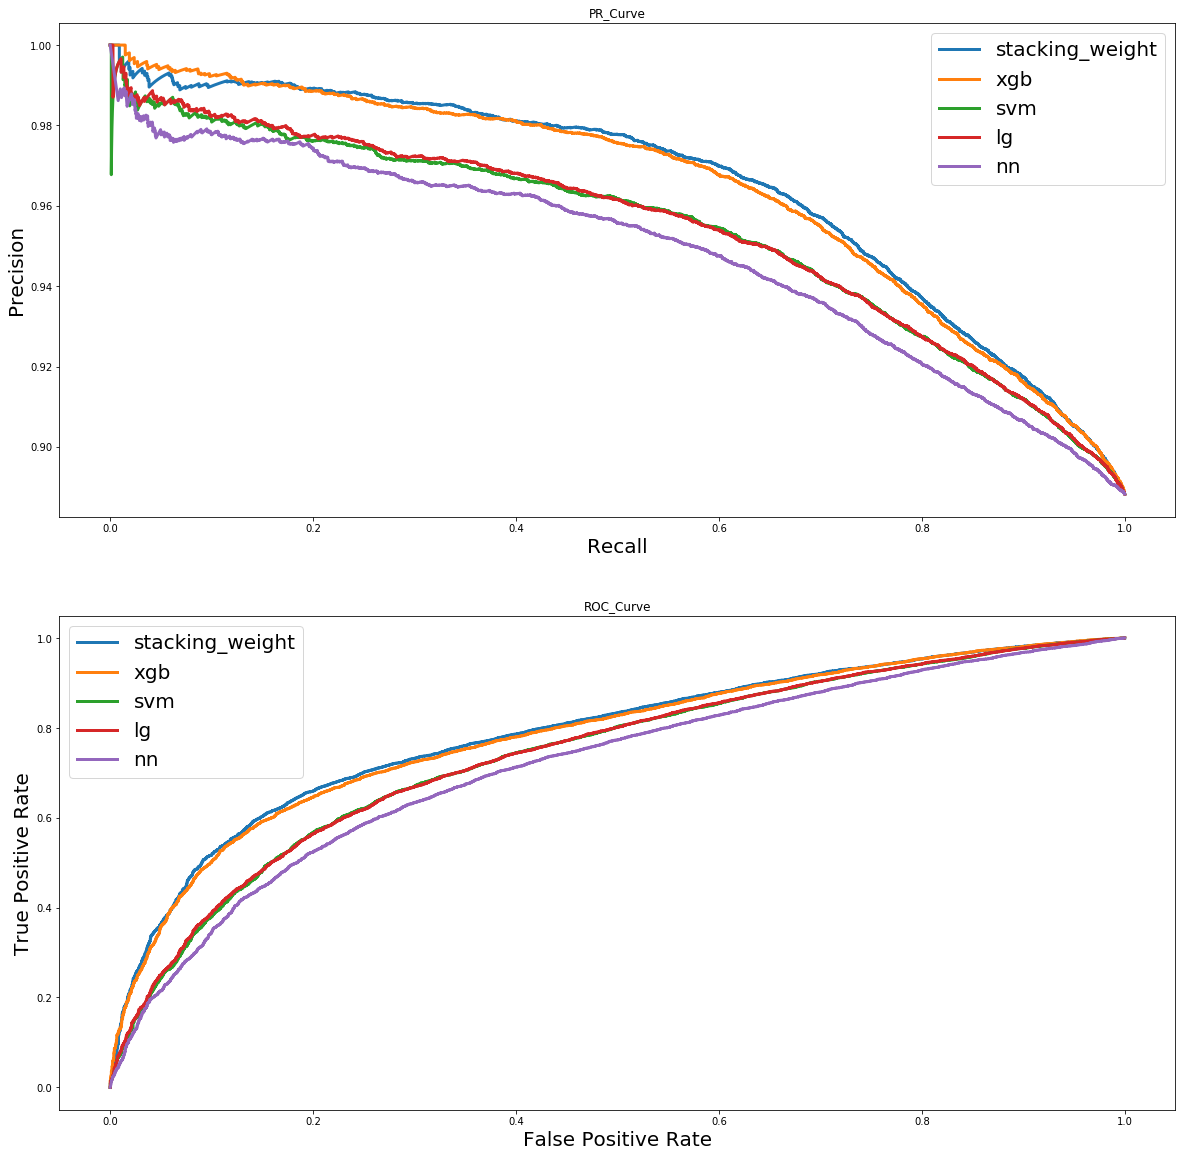

In [26]:
plot_Curve({"stacking_weight":direct,"xgb":xgb_gmm_prob,"svm":SVM_gmm_prob,"lg":lg_gmm_prob,"nn":nn_gmm_prob},y_test)

In [21]:
# count running time

end = time.time()
print("Runtime: %g" % (end - start))

Runtime: 397.681
